In [47]:
import pandas as pd
import csv
import numpy as np

# get the columns names from train.csv using csv readinf the first row
with open('leap-atmospheric-physics-ai-climsim/train.csv', 'r') as f:
    reader = csv.reader(f)
    columns = next(reader)

# read the npy file
df = pd.DataFrame(np.load('data/split_1.npy'), columns=columns[1:])

def estimate_heating_tendency(df):
    heating_tendency = np.zeros((df.shape[0], 60))
    for i in range(60):
        heating_tendency[:, i] = (
            df[f'pbuf_LHFLX'] + df[f'pbuf_SHFLX'] + df[f'pbuf_SOLIN'] * (1 - (df['cam_in_ALDIF'] + df['cam_in_ALDIR'] + df['cam_in_ASDIF'] + df['cam_in_ASDIR']))
        ) / (df[f'state_t_{i}'] * 1004)  # Assuming air specific heat capacity (Cp) ~ 1004 J/kg/K
    return heating_tendency

def estimate_moistening_tendency(df):
    moistening_tendency = np.zeros((df.shape[0], 60))
    for i in range(60):
        moistening_tendency[:, i] = (
            df[f'state_q0001_{i}'] * df['pbuf_LHFLX'] / (df['state_ps'] * 2.5e6)  # Assuming latent heat of vaporization ~ 2.5e6 J/kg
        )
    return moistening_tendency

def estimate_cloud_liquid_mixing_ratio_change(df):
    cloud_liquid_mixing_ratio_change = np.zeros((df.shape[0], 60))
    for i in range(60):
        cloud_liquid_mixing_ratio_change[:, i] = (
            df[f'state_q0002_{i}'] * df[f'state_t_{i}'] * df['pbuf_SOLIN']
        ) / (df['state_ps'] * 2.5e6)  # Assuming latent heat of vaporization ~ 2.5e6 J/kg
    return cloud_liquid_mixing_ratio_change

def estimate_zonal_wind_acceleration(df):
    zonal_wind_acceleration = np.zeros((df.shape[0], 60))
    for i in range(60):
        zonal_wind_acceleration[:, i] = (
            df[f'state_u_{i}'] * df['pbuf_TAUX'] / df['state_ps']
        )
    return zonal_wind_acceleration

def estimate_meridional_wind_acceleration(df):
    meridional_wind_acceleration = np.zeros((df.shape[0], 60))
    for i in range(60):
        meridional_wind_acceleration[:, i] = (
            df[f'state_v_{i}'] * df['pbuf_TAUY'] / df['state_ps']
        )
    return meridional_wind_acceleration

def estimate_net_shortwave_flux(df):
    return (
        df['pbuf_SOLIN'] * (1 - (df['cam_in_ALDIF'] + df['cam_in_ALDIR'] + df['cam_in_ASDIF'] + df['cam_in_ASDIR']))
    )

def estimate_downward_longwave_flux(df):
    downward_longwave_flux = np.zeros((df.shape[0], 60))
    for i in range(60):
        downward_longwave_flux[:, i] = (
            df['cam_in_LWUP'] + 5.67e-8 * (df[f'state_t_{i}'] ** 4)  # Stefan-Boltzmann constant ~ 5.67e-8 W/m²K⁴
        )
    return downward_longwave_flux

# Apply the functions to the DataFrame
df[['estimated_ptend_t_' + str(i) for i in range(60)]] = estimate_heating_tendency(df)
df[['estimated_ptend_q0001_' + str(i) for i in range(60)]] = estimate_moistening_tendency(df)
df[['estimated_ptend_q0002_' + str(i) for i in range(60)]] = estimate_cloud_liquid_mixing_ratio_change(df)
df[['estimated_ptend_u_' + str(i) for i in range(60)]] = estimate_zonal_wind_acceleration(df)
df[['estimated_ptend_v_' + str(i) for i in range(60)]] = estimate_meridional_wind_acceleration(df)
df['estimated_cam_out_NETSW'] = estimate_net_shortwave_flux(df)
df[['estimated_cam_out_FLWDS_' + str(i) for i in range(60)]] = estimate_downward_longwave_flux(df)



/var/folders/wh/srwjqw_j5gsbl1y7xdb9jc900000gn/T/ipykernel_24417/2136744645.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['estimated_ptend_q0001_' + str(i) for i in range(60)]] = estimate_moistening_tendency(df)
/var/folders/wh/srwjqw_j5gsbl1y7xdb9jc900000gn/T/ipykernel_24417/2136744645.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[['estimated_ptend_q0001_' + str(i) for i in range(60)]] = estimate_moistening_tendency(df)
/var/folders/wh/srwjqw_j5gsbl1y7xdb9jc900000gn/T/ipykernel_24417/2136744645.py:68: Perfo

In [48]:
from sklearn.metrics import mean_squared_error

mse_ptend_t = mean_squared_error(df[[f'ptend_t_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_ptend_t_{i}' for i in range(60)]].values.flatten())
mse_ptend_q0001 = mean_squared_error(df[[f'ptend_q0001_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_ptend_q0001_{i}' for i in range(60)]].values.flatten())
mse_ptend_q0002 = mean_squared_error(df[[f'ptend_q0002_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_ptend_q0002_{i}' for i in range(60)]].values.flatten())
mse_ptend_u = mean_squared_error(df[[f'ptend_u_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_ptend_u_{i}' for i in range(60)]].values.flatten())
mse_ptend_v = mean_squared_error(df[[f'ptend_v_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_ptend_v_{i}' for i in range(60)]].values.flatten())
mse_cam_out_NETSW = mean_squared_error(df['cam_out_NETSW'], df['estimated_cam_out_NETSW'])
# mse_cam_out_FLWDS = mean_squared_error(df[[f'cam_out_FLWDS_{i}' for i in range(60)]].values.flatten(), df[[f'estimated_cam_out_FLWDS_{i}' for i in range(60)]].values.flatten())

# Print the MSE for each target variable
print(f'MSE for Heating Tendency (ptend_t): {mse_ptend_t}')
print(f'MSE for Moistening Tendency (ptend_q0001): {mse_ptend_q0001}')
print(f'MSE for Cloud Liquid Mixing Ratio Change (ptend_q0002): {mse_ptend_q0002}')
print(f'MSE for Zonal Wind Acceleration (ptend_u): {mse_ptend_u}')
print(f'MSE for Meridional Wind Acceleration (ptend_v): {mse_ptend_v}')
print(f'MSE for Net Shortwave Flux at Surface (cam_out_NETSW): {mse_cam_out_NETSW}')
# print(f'MSE for Downward Longwave Flux at Surface (cam_out_FLWDS): {mse_cam_out_FLWDS}')

MSE for Heating Tendency (ptend_t): 4.591263132930613e-06
MSE for Moistening Tendency (ptend_q0001): 1.0275359333815935e-15
MSE for Cloud Liquid Mixing Ratio Change (ptend_q0002): 2.710016540187079e-17
MSE for Zonal Wind Acceleration (ptend_u): 5.703444298846286e-10
MSE for Meridional Wind Acceleration (ptend_v): 2.533680041744981e-10
MSE for Net Shortwave Flux at Surface (cam_out_NETSW): 73152.39515281646


In [57]:
mse_mean_cam_out_NETSW = mean_squared_error(df['cam_out_NETSW'], df['cam_out_NETSW'].mean() * np.ones(100915))
mse_mean_ptend_q0001_1 = mean_squared_error(df['ptend_q0001_1'], df['ptend_q0001_1'].mean() * np.ones(100915))
mse_mean_ptend_q0001_1

1.1045166519763515e-28

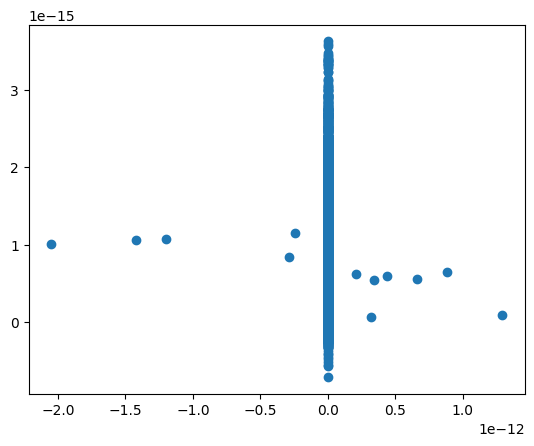

In [53]:
# plot true vs estimated
import matplotlib.pyplot as plt
plt.scatter(df['ptend_q0001_1'],df['estimated_ptend_q0001_1'])

(-5e-14, 5e-14)

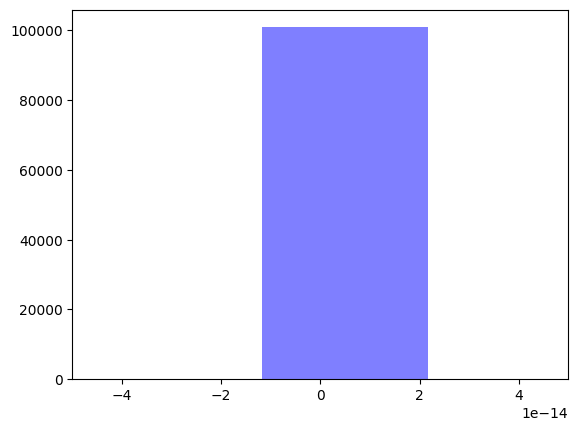